Pierre Nikitits
## Course Project: Electricity Price Explanation

Dataset:

- Consumption
- Exchange
- Net Export/Import
- Energy Sources
- Residual Load
- Weather Conditions
- Market Dynamics

Steps:

1. Preprocessing Data
2. Metric definition
3. Define models: Random Forest, Linear Regression, SVR
4. Hyperparameter Tuning: Grid Search
5. Evaluation
6. Interpretation


## Loading and Preprocessing the data

In [1]:
import pandas as pd
path = "/Users/pierre/Documents/GitHub/EnsembleLearningProject/Data/"

X_train = pd.read_csv(path + 'X_train.csv').set_index('ID')
y_train = pd.read_csv(path + 'y_train.csv').set_index('ID')
X_test = pd.read_csv(path + 'X_test.csv').set_index('ID')
y_test = pd.read_csv(path + 'y_test.csv').set_index('ID')

In [2]:
print("X_train :" , X_train.shape)
print("y_train :" , y_train.shape)

print("\nX_test  :" , X_test.shape)
print("y_test  :" , y_test.shape)

X_train : (1494, 34)
y_train : (1494, 1)

X_test  : (654, 34)
y_test  : (654, 1)


In [3]:
X_train.drop(columns=['COUNTRY' , 'DAY_ID'], inplace=True)
X_test.drop(columns=['COUNTRY' , 'DAY_ID'], inplace=True)

In [4]:
X_train.head()

,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
ID,,,,,,,,,,,,,,,,,,,,,
1054,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,-0.692860,0.441238,-0.213766,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
2049,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,1.130838,0.174773,0.426940,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
1924,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,1.682587,2.351913,2.122241,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
297,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,-0.563230,0.487818,0.194659,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
1101,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,-0.990324,0.238693,-0.240862,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [5]:
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

In [6]:
print(X_train.shape)
print(y_train.shape)

(1276, 32)
(1276, 1)


## Metrics
- Mean Squared Error
- Root Mean Squared Error
- Mean Absolute Error
- R-squared
- Mean Absolute Percentage Error


In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score , mean_absolute_percentage_error , log_loss
from math import sqrt

def find_metrics(y_test_values , predicted_values):
    mse = mean_squared_error(y_test_values, predicted_values)
    print("Mean Squared Error:", mse)

    rmse = sqrt(mean_squared_error(y_test_values, predicted_values))
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    mae = mean_absolute_error(y_test_values, predicted_values)
    print(f"Mean Absolute Error (MAE): {mae}")

    r2 = r2_score(y_test_values, predicted_values)
    print(f"R-squared (R²): {r2}")

    mape = mean_absolute_percentage_error(y_test_values, predicted_values)
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

    # loss1 = log_loss(y_test_values , predicted_values)
    # print(f"log loss: {loss1}")



## Models Definitions

1. Random Forest
2. Linear Regression
3. SVR

## 1. Random Forest

In [14]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape_error



def objective_rand_forest(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 200, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 11)
    min_samples_split = trial.suggest_int('min_samples_split', 4, 11)

    
    random_forest = RandomForestRegressor(
        random_state=11,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split
    )
    
    random_forest.fit(X_train, y_train.values.ravel())
    pred = random_forest.predict(X_test)

    
    error = mape_error(y_test, pred)

    trial.report(error, step=0)

    if trial.should_prune():
        raise optuna.TrialPruned()

    return error


pruner = optuna.pruners.MedianPruner()


study_rand_forest = optuna.create_study(direction='minimize',
                            pruner=pruner,
                            study_name="example_study_with_pruning",
                            storage='sqlite:///example_study_with_pruning.db',
                            load_if_exists=True)

study_rand_forest.optimize(objective_rand_forest, n_trials=100 , n_jobs=-1)


[I 2024-03-03 18:44:49,615] A new study created in RDB with name: example_study_with_pruning
[I 2024-03-03 18:44:56,573] Trial 2 finished with value: 2.530427168518719 and parameters: {'n_estimators': 440, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 2 with value: 2.530427168518719.
[I 2024-03-03 18:44:58,784] Trial 7 finished with value: 3.505404953539682 and parameters: {'n_estimators': 265, 'max_depth': 7, 'min_samples_split': 11}. Best is trial 2 with value: 2.530427168518719.
[I 2024-03-03 18:45:07,668] Trial 9 finished with value: 3.559016381989093 and parameters: {'n_estimators': 288, 'max_depth': 7, 'min_samples_split': 7}. Best is trial 2 with value: 2.530427168518719.
[I 2024-03-03 18:45:08,569] Trial 6 finished with value: 4.057221747037212 and parameters: {'n_estimators': 518, 'max_depth': 8, 'min_samples_split': 7}. Best is trial 2 with value: 2.530427168518719.
[I 2024-03-03 18:45:10,622] Trial 1 finished with value: 4.4016724692326035 and parameters: {'n_estima

In [15]:
print(f"Best trial: {study_rand_forest.best_trial}")
print(f"Best parameters: {study_rand_forest.best_params}")
print(f"Best value (accuracy): {study_rand_forest.best_value}")

Best trial: FrozenTrial(number=81, state=1, values=[2.3548131448398624], datetime_start=datetime.datetime(2024, 3, 3, 18, 46, 49, 116179), datetime_complete=datetime.datetime(2024, 3, 3, 18, 46, 53, 293653), params={'n_estimators': 323, 'max_depth': 2, 'min_samples_split': 10}, user_attrs={}, system_attrs={}, intermediate_values={0: 2.3548131448398624}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=200, step=1), 'max_depth': IntDistribution(high=11, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=11, log=False, low=4, step=1)}, trial_id=82, value=None)
Best parameters: {'n_estimators': 323, 'max_depth': 2, 'min_samples_split': 10}
Best value (accuracy): 2.3548131448398624


In [50]:
random_forest = RandomForestRegressor(random_state=42 , n_estimators=323 , max_depth=2 , min_samples_split=10)
random_forest.fit(X_train, y_train.values.ravel())

random_forest_pred = random_forest.predict(X_test)
find_metrics(y_test['TARGET'].values , random_forest_pred)

Mean Squared Error: 1.104491606844341
Root Mean Squared Error (RMSE): 1.050947956296762
Mean Absolute Error (MAE): 0.8460797895221016
R-squared (R²): -0.051758170734791165
Mean Absolute Percentage Error (MAPE): 2.4003542132188103%


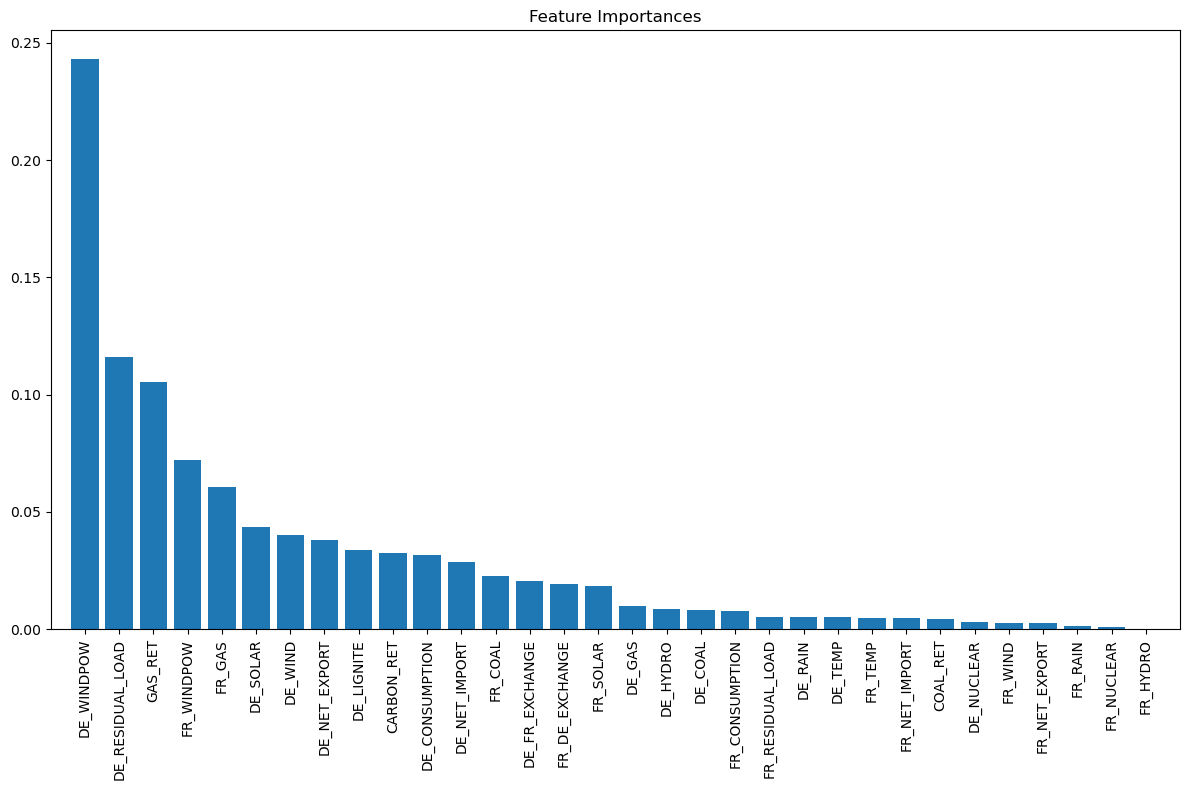

In [61]:
import numpy as np
import matplotlib.pyplot as plt


feature_importances = random_forest.feature_importances_
feature_names = X_train.columns
sorted_indices = np.argsort(feature_importances)[::-1]


plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align="center")
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)
plt.xlim([-1, len(feature_importances)])
plt.tight_layout()
plt.show()

## 2. Linear Regression

In [57]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train.values.ravel())

linear_pred = linear_regression.predict(X_test)
find_metrics(y_test , linear_pred)

Mean Squared Error: 1.1518256780029095
Root Mean Squared Error (RMSE): 1.0732314186618417
Mean Absolute Error (MAE): 0.8674191694960335
R-squared (R²): -0.09683229876497612
Mean Absolute Percentage Error (MAPE): 2.7917000979889517%


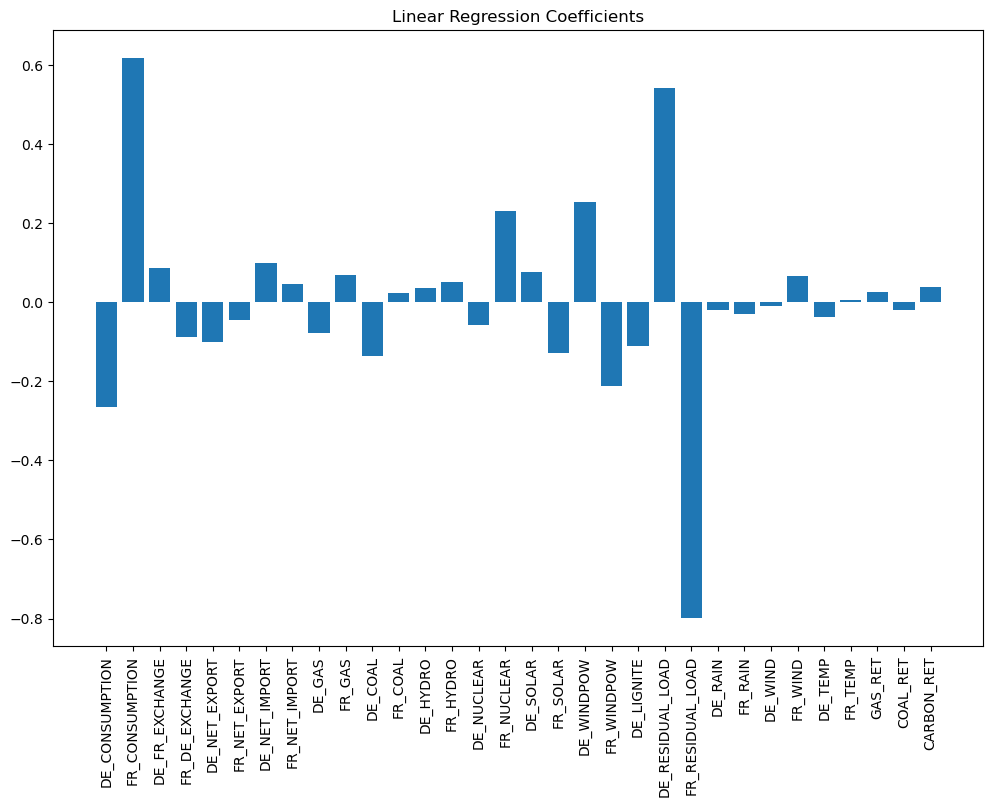

In [62]:
coefficients = linear_regression.coef_
feature_names = X_train.columns

plt.figure(figsize=(12, 8))
plt.bar(feature_names, coefficients)
plt.xticks(rotation=90)
plt.title("Linear Regression Coefficients")
plt.show()


## 3. SVR

In [54]:
from sklearn.svm import SVR

def objective_svr(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    C = trial.suggest_float('C', 0.1, 1)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    svr = SVR(kernel=kernel , C=C , gamma=gamma)
    svr.fit(X_train, y_train.values.ravel())
    svr_pred = svr.predict(X_test)

    error = mape_error(y_test, svr_pred)
    return error

svr_study = optuna.create_study(direction='minimize',
                            study_name="SVR_study",
                            storage='sqlite:///SVR_study.db',
                            load_if_exists=True)

svr_study.optimize(objective_svr, n_trials=1000 , n_jobs=-1)

print(f"Best trial: {svr_study.best_trial}")
print(f"Best parameters: {svr_study.best_params}")
print(f"Best value (accuracy): {svr_study.best_value}")

[I 2024-03-04 14:52:36,709] A new study created in RDB with name: SVR_study
[I 2024-03-04 14:52:37,205] Trial 3 finished with value: 1.4085230448013544 and parameters: {'kernel': 'rbf', 'C': 0.4897444580327066, 'gamma': 'scale'}. Best is trial 3 with value: 1.4085230448013544.
[I 2024-03-04 14:52:37,310] Trial 0 finished with value: 1.3983159264591491 and parameters: {'kernel': 'rbf', 'C': 0.48159726237832723, 'gamma': 'scale'}. Best is trial 0 with value: 1.3983159264591491.
[I 2024-03-04 14:52:37,430] Trial 1 finished with value: 1.2228172192913784 and parameters: {'kernel': 'linear', 'C': 0.6419307989627769, 'gamma': 'scale'}. Best is trial 1 with value: 1.2228172192913784.
[I 2024-03-04 14:52:37,452] Trial 4 finished with value: 1.4437348331267255 and parameters: {'kernel': 'rbf', 'C': 0.18272113297895443, 'gamma': 'scale'}. Best is trial 1 with value: 1.2228172192913784.
[I 2024-03-04 14:52:37,516] Trial 2 finished with value: 1.2163258741298273 and parameters: {'kernel': 'linear'

Best trial: FrozenTrial(number=579, state=1, values=[1.2108300626073523], datetime_start=datetime.datetime(2024, 3, 4, 14, 53, 22, 215091), datetime_complete=datetime.datetime(2024, 3, 4, 14, 53, 22, 602048), params={'kernel': 'linear', 'C': 0.25866321948522847, 'gamma': 'scale'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'rbf')), 'C': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'gamma': CategoricalDistribution(choices=('scale', 'auto'))}, trial_id=580, value=None)
Best parameters: {'kernel': 'linear', 'C': 0.25866321948522847, 'gamma': 'scale'}
Best value (accuracy): 1.2108300626073523


In [55]:
from sklearn.svm import SVR

svr = SVR(kernel='linear' , C=0.25866321948522847 , gamma='scale')
svr.fit(X_train, y_train.values.ravel())

svr_pred = svr.predict(X_test)
find_metrics(y_test , svr_pred)

Mean Squared Error: 1.077497617797766
Root Mean Squared Error (RMSE): 1.0380258271342606
Mean Absolute Error (MAE): 0.8335388734246175
R-squared (R²): -0.026052997092433472
Mean Absolute Percentage Error (MAPE): 1.2108300626073523%


TypeError: only size-1 arrays can be converted to Python scalars

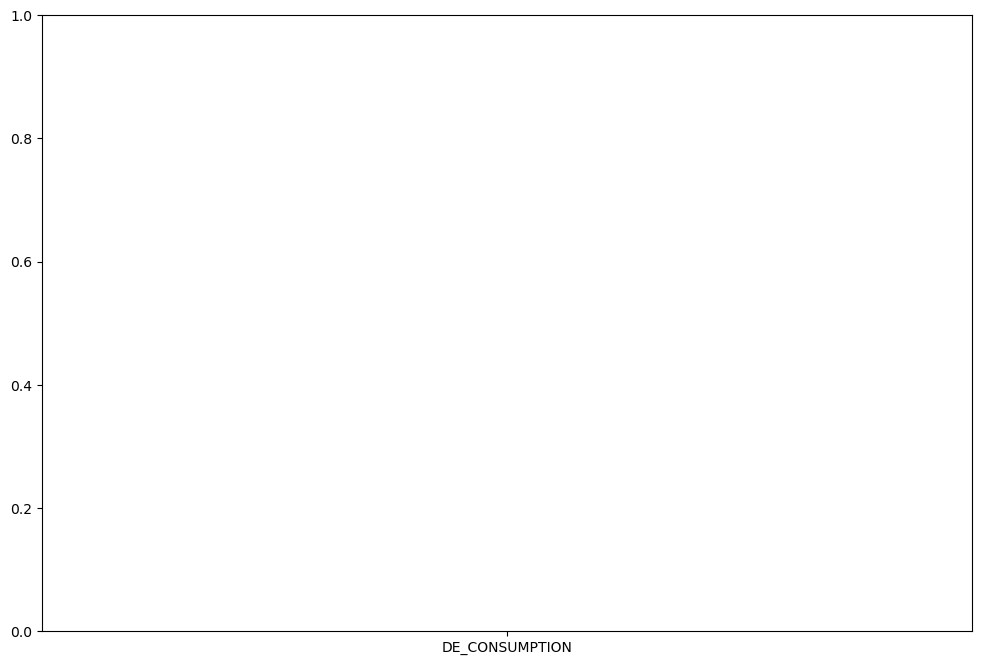

In [64]:
coefficients = svr.coef_.flatten()

plt.figure(figsize=(12, 8))
plt.bar(feature_names, coefficients)
plt.xticks(rotation=90)
plt.title("SVR Coefficients")
plt.show()

## Ensemble voting

In [58]:
from sklearn.ensemble import VotingRegressor

voting_ensemble = VotingRegressor([('rf', random_forest), ('lr', linear_regression), ('svr', svr)])
voting_ensemble.fit(X_train, y_train.values.ravel())

y_pred_voting = voting_ensemble.predict(X_test)
find_metrics(y_test , y_pred_voting)

Mean Squared Error: 1.0985799377430576
Root Mean Squared Error (RMSE): 1.0481316414186996
Mean Absolute Error (MAE): 0.8447968444470155
R-squared (R²): -0.04612875151473972
Mean Absolute Percentage Error (MAPE): 2.101581345046364%


In [59]:
from sklearn.ensemble import StackingRegressor

stacking_ensemble = StackingRegressor([('rf', random_forest), ('lr', linear_regression), ('svr', svr)],
                                      final_estimator=LinearRegression())
stacking_ensemble.fit(X_train, y_train.values.ravel())

y_pred_stacking = stacking_ensemble.predict(X_test)
find_metrics(y_test , y_pred_stacking)

Mean Squared Error: 1.1055083269008796
Root Mean Squared Error (RMSE): 1.051431560730835
Mean Absolute Error (MAE): 0.8460777358368019
R-squared (R²): -0.05272634796691156
Mean Absolute Percentage Error (MAPE): 1.8897367969789074%
